In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from transformers import AutoTokenizer
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.wacky_scores_utils import sort_and_get_top_n, sort_and_get_top_n_bm25, chunk_wackiness_and_stack

SEEDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 42]

CONFIG = {
    "BM25 + RM3": {
        "tokenizer": None,
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/rm3_wacky_scores_seed_{seed}.json",
    },
    "BM25 + Query2Doc": {
        "tokenizer": None,
        "seeds": [42, 0, 1, 2, 3, 4],
        "path": "experiments/wackiness_scores/query2doc_wacky_scores_seed_{seed}.json",
    },
    "SPLADE-L1": {
        "tokenizer": "naver/splade_v2_max",
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/splade_v2_l1_wacky_scores_seed_{seed}.json",
    },
    "SPLADE-v3": {
        "tokenizer": "naver/splade-v3",
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/splade_v3_wacky_scores_seed_{seed}.json",
    },
    "SPLADE-v2 Reproduction": {
        "tokenizer": "naver/splade_v2_max",
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/splade_v2_repro_wacky_scores_seed_{seed}.json",
    },
    "SPLADE-v2-SUM": {
        "tokenizer": "naver/splade_v2_max",
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/splade_v2_sum_wacky_scores_seed_{seed}.json",
    },
    "Splade-v2-CLS": {
        "tokenizer": "naver/splade_v2_max",
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/splade_v2_cls_wackiness_scores_seed_{seed}.json",
    },
    "SPLADE-v2": {
        "tokenizer": "naver/splade_v2_max",
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/splade_v2_wacky_scores_seed_{seed}.json",
    },
    "SPLADE-v2-NQ": {
        "tokenizer": "naver/splade_v2_max",
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/splade_v2_nq_wacky_scores_seed_{seed}.json",
    },
    "SPLADE-v2-ModernBERT": {
        "tokenizer": "answerdotai/ModernBERT-base",
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/splade_v2_modernbert_wacky_scores_seed_{seed}.json",
    },
    "SPLADE-v2-DistilRoBERTa": {
        "tokenizer": "distilbert/distilroberta-base",
        "seeds": SEEDS,
        "path": "experiments/wackiness_scores/splade_v2_distilroberta_wacky_scores_seed_{seed}.json",
    },
}

N_CHUNKS = 1000

Load precomputed wackiness scores for all models and random seeds

In [11]:
wacky_scores = {
    name: [
        json.load(open(cfg["path"].format(seed=seed), "r"))
        for seed in cfg["seeds"]
    ]
    for name, cfg in CONFIG.items()
}

tokenizers = {
    name: AutoTokenizer.from_pretrained(cfg["tokenizer"]) for name, cfg in CONFIG.items() if cfg["tokenizer"]
}

wacky_scores = {
    name: [
        sort_and_get_top_n_bm25(seed_scores, n=len(seed_scores), normalize=True) if "BM25" in name else sort_and_get_top_n(seed_scores, n=len(seed_scores), tokenizer=tokenizers[name], normalize=True)
        for seed_scores in scores
    ]
    for name, scores in wacky_scores.items()
}

Chunk wackiness curves to normalize for different tokenizer vocabulary sizes and plot curves

In [15]:
wacky_curves = {
    name: chunk_wackiness_and_stack(scores, n_chunks=N_CHUNKS) for name, scores in wacky_scores.items()
}

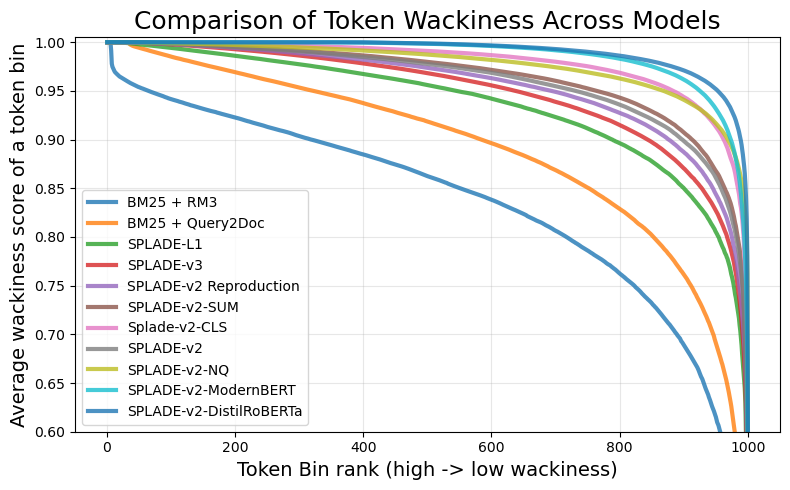

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

for name in wacky_curves.keys():
    mean_curve = np.mean(wacky_curves[name], axis=0)
    x = np.arange(1, len(mean_curve) + 1)
    ax.plot(range(1, len(mean_curve)+1), mean_curve, label=name, linewidth=3, alpha=0.8)
    
ax.set_xlabel('Token Bin rank (high -> low wackiness)', fontsize=14)
ax.set_ylabel('Average wackiness score of a token bin', fontsize=14)
ax.set_title('Comparison of Token Wackiness Across Models', fontsize=18)

ax.grid(True, alpha=0.3)
ax.legend()
ax.set_ylim(0.6, 1.005)

fig.tight_layout()

Calculate W-AUC scores

In [23]:
statistics = []
for name, curves in wacky_curves.items():
    x = np.arange(1, curves.shape[1] + 1)
    per_seed_auc = np.trapezoid(curves, x=x, axis=1)
    auc_mean = per_seed_auc.mean() / N_CHUNKS
    auc_std = per_seed_auc.std() / N_CHUNKS
    statistics.append({
        "model": name,
        "auc_mean": auc_mean,
        "2x_auc_std": 2 * auc_std,
    })

statistics = pd.DataFrame(statistics).sort_values("auc_mean", ascending=True).round(3)
statistics

,model,auc_mean,2x_auc_std
0,BM25 + RM3,0.833,0.057
1,BM25 + Query2Doc,0.890,0.023
2,SPLADE-L1,0.934,0.002
3,SPLADE-v3,0.947,0.033
4,SPLADE-v2 Reproduction,0.953,0.001
7,SPLADE-v2,0.959,0.002
5,SPLADE-v2-SUM,0.962,0.001
8,SPLADE-v2-NQ,0.976,0.000
6,Splade-v2-CLS,0.977,0.001
9,SPLADE-v2-ModernBERT,0.985,0.001
